## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [2]:
# Computing the camera calibration matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

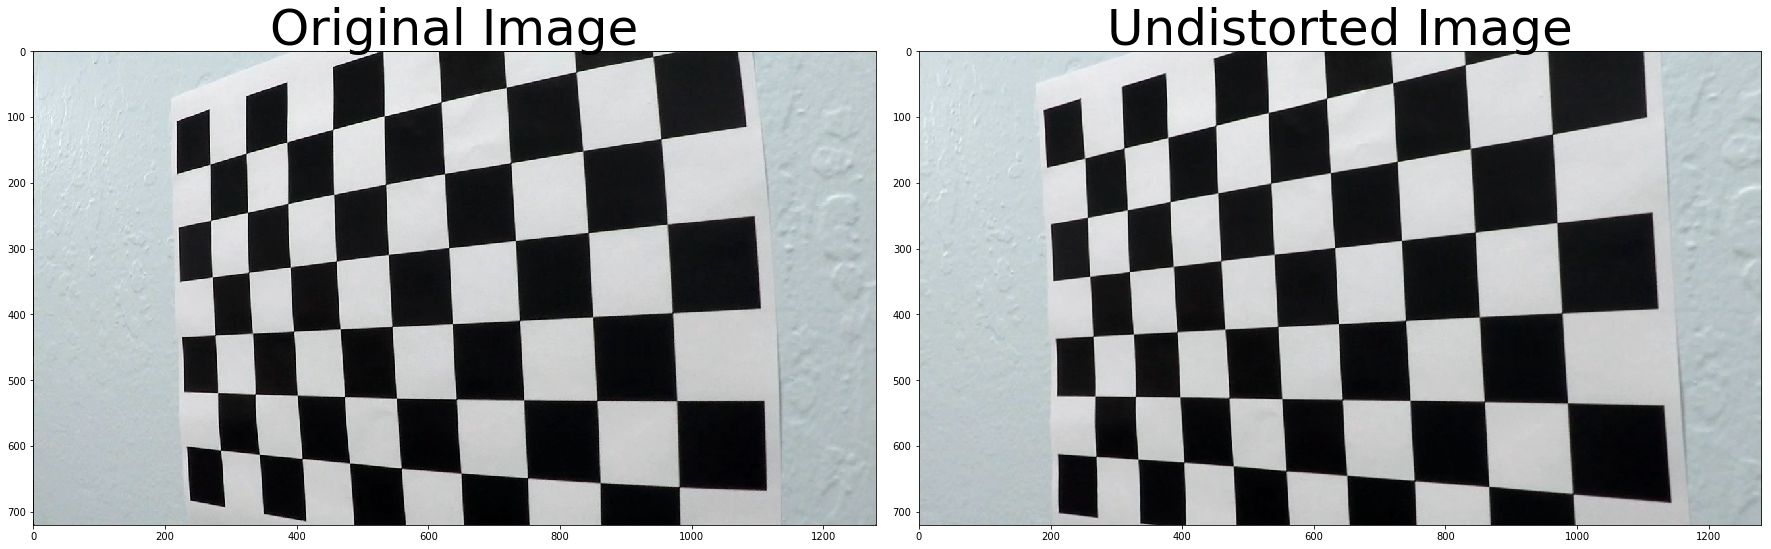

In [3]:
# Original image vs Undistorted image

img = cv2.imread('../camera_cal/calibration4.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
# Defining functions for Sobel threshold, Magnitude threshold, Direction threshold, S-channel-threshold and Region of Interest

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [8]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [9]:
# Code for defining region of interest, from my Project1
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [10]:
#Defining function for final thresholded image

In [11]:
def threshold_image(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Applying gradient in the x-direction to emphasize edges closer to vertical
    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=100)
    
    #Applying threshold on the magnitude(abs value of gradients in x&y directions)
    mag_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 100))
    
    #Applying direction threshold to identify on those edges closer to vertical
    dir_binary = dir_threshold(gray, sobel_kernel=3, thresh=(np.pi/4, np.pi/2))
    
    #Combining above three thresholds  
    combined = ((gradx == 1) & (mag_binary == 1) & (dir_binary == 1))
    
    #Applying HLS binary
    hls_binary = hls_select(img, thresh=(90, 255))
    
    # Applying Red & Green thresholds to detect yellow lanes properly.
    rg_thresh = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > rg_thresh) & (G > rg_thresh)
        
    # Threshold on L channel to avoid dark pixels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]    
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])
    
    #Creating combined condition
    combined_binary = np.zeros_like(gradx)
    combined_binary[((hls_binary == 1) | (combined == 1)) & (r_g_condition & l_condition)] = 1
    
    #return combined_binary
    
    imshape = img.shape
    vertices = np.array([[(180,imshape[0]),(545, 400), (775, 400), (1150,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(combined_binary, vertices)
    
    return masked_edges    

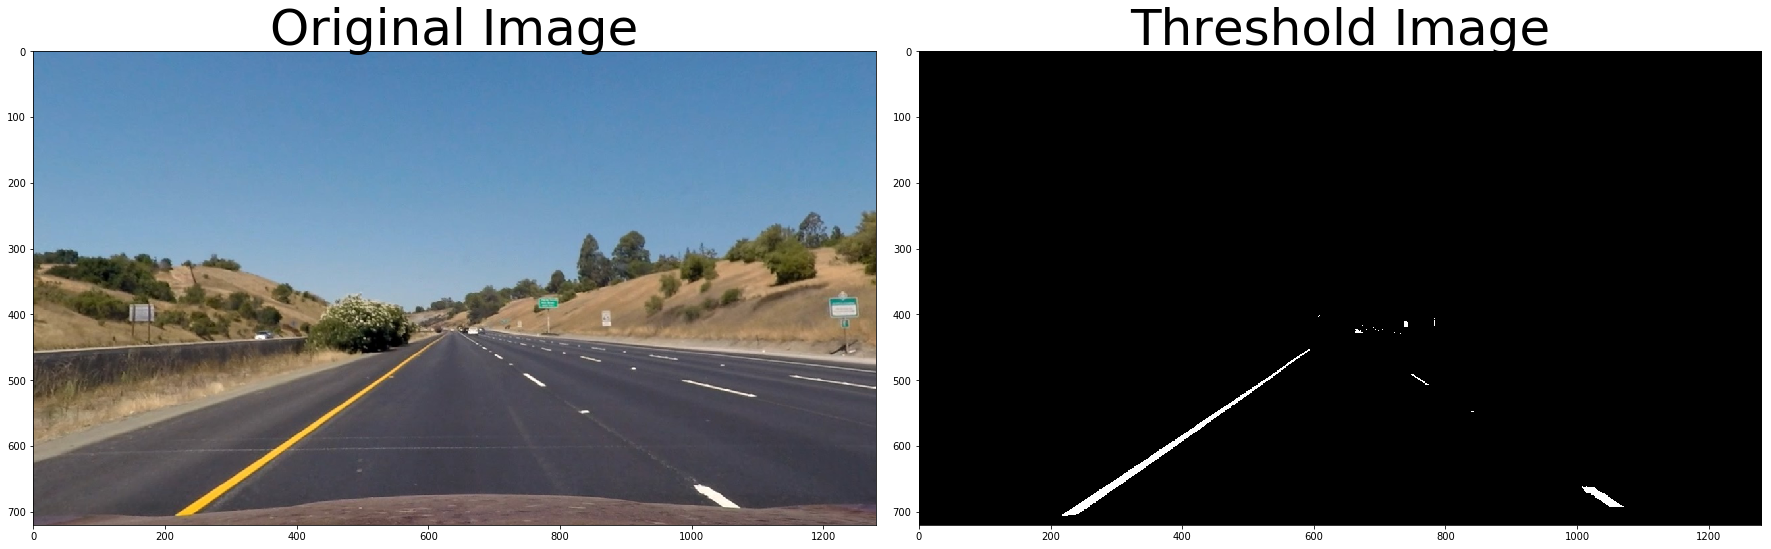

In [12]:
# Original Undistorted image vs Threshold image
import matplotlib.image as mpimg

image = mpimg.imread('../test_images/straight_lines1.jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
threshold = threshold_image(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(threshold, cmap = 'gray')
ax2.set_title('Threshold Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [13]:
# Applying Perspective transform

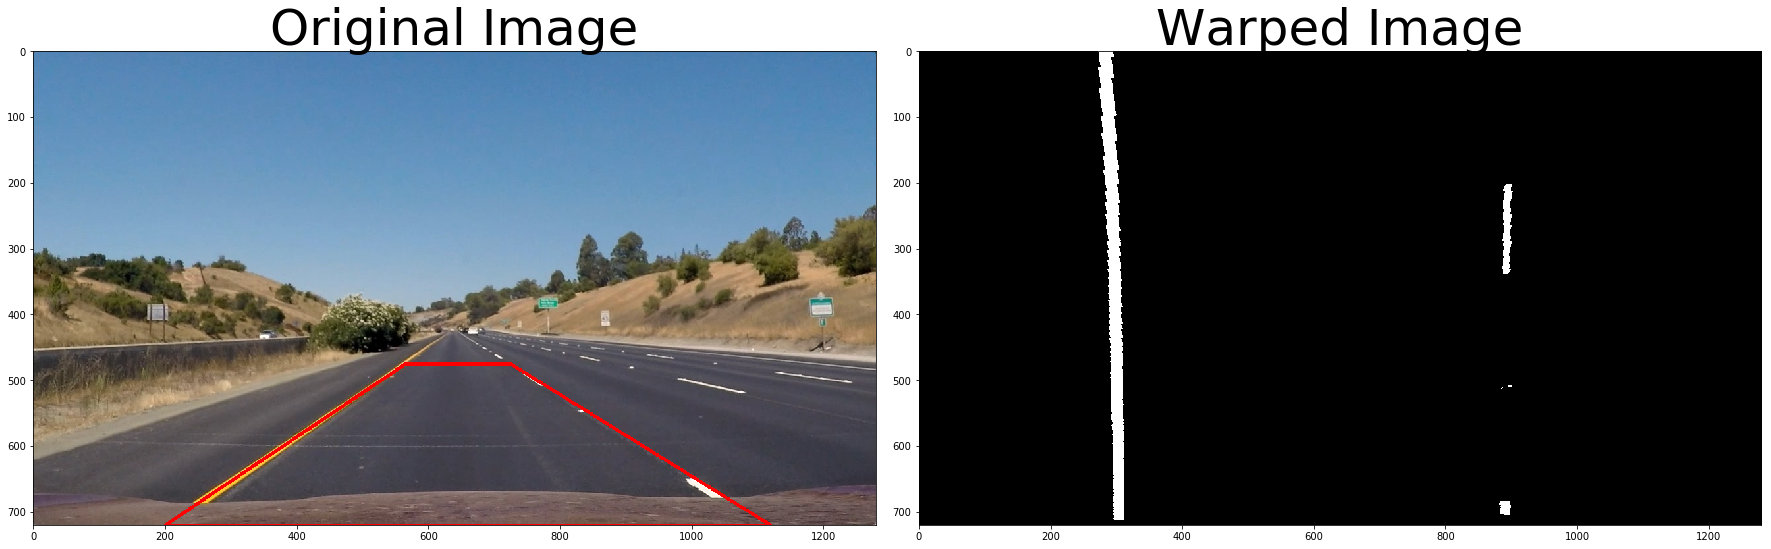

In [14]:
imshape = image.shape
img_size = (imshape[1], imshape[0])

# Defining source points manually from the example image

bottom_left = [200,imshape[0]]
bottom_right = [1120, imshape[0]]
top_left = [565, 475]
top_right = [725, 475]

src = np.float32([bottom_left,bottom_right,top_right,top_left])

vertices = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
vertices = vertices.reshape((-1,1,2))
copy = image.copy()
cv2.polylines(copy,[vertices],True,(255,0,0), thickness=4)

# Defining destination points manually from the example image such that they form a rectangle

bottom_left = [300,imshape[0]]
bottom_right = [900, imshape[0]]
top_left = [300, 0]
top_right = [900, 0]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src) #Used to draw warped image back on to Original image

warped = cv2.warpPerspective(threshold, M, img_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap = 'gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


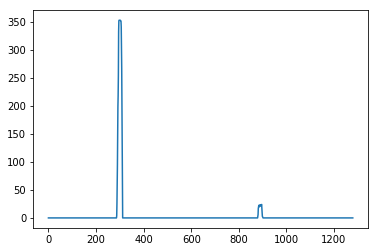

In [15]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [16]:
#Applying sliding window search to identify non-zero pixels

binary_warped = warped
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

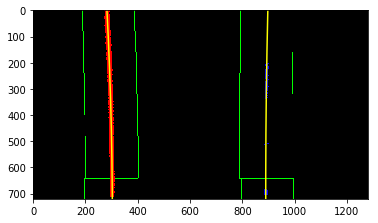

In [17]:
# Generate x and y values for plotting

ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

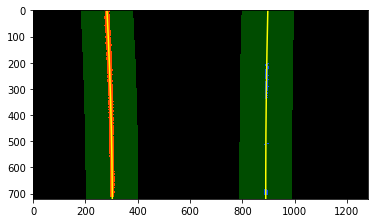

In [18]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Create an image to draw on and an image to show the selection window

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [19]:
#Function to measure readius of curvature

def rad_curvature(ploty, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

In [20]:
left_curverad, right_curverad = rad_curvature(ploty, left_fit, right_fit)
avg_curverad = (left_curverad + right_curverad)/2
curvature = "Radius of curvature = %.2f m" % avg_curverad
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

4984.53201967 m 9427.60766168 m


In [21]:
#Funstion to measure difference in the left and right radii of curvature, the two curves are supposed to be
#approximately parallel and this function will help in weeding out bad results
def difference_in_curvature(ploty, left_fit, right_fit):
    left_curverad, right_curverad = rad_curvature(ploty, left_fit, right_fit)
    return abs(left_curverad - right_curverad) 

In [22]:
# Measure offset of the vehicle from the center
num_rows = warped.shape[0]
center_line = (right_fitx[num_rows-1] + left_fitx[num_rows-1])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - center_line)
center_offset_meters = xm_per_pix*center_offset_pixels
offset = "Offset of vehicle: %.2f m" % center_offset_meters

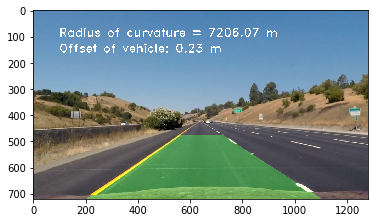

In [23]:
#Outputting final processed image

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

cv2.putText(result,curvature , (100, 100), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), thickness=2)
cv2.putText(result, offset, (100, 160), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), thickness=2)
    
plt.imshow(result)

In [24]:
#Function for Sliding window search to find non-zero pixels

def sliding_window_search(binary_warped):
        
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if(lefty.size == 0 or leftx.size == 0):
        return None, None
    
    if(righty.size == 0 or rightx.size == 0):
        return None, None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    return left_fit, right_fit

In [25]:
#Function to predict further lines once the line positions are identified through sliding window search

def predict_lines(binary_warped):
    global left_fit
    global right_fit
      
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if(lefty.size == 0 or leftx.size == 0):
        return None, None
    
    if(righty.size == 0 or rightx.size == 0):
        return None, None
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit   

In [26]:
#Defining a function to compute the average of good lines in previous frames.
#The logic that defines whether the lines are good are not is written in the final pipeline.

def averaged_line(previous_lines, new_line):
      
    # Number of previous frames considered for the average. Started with 20 and brought
    #it down to 5. A lower number helps in avoiding over generalization thus preventing wobbling of the lanes 
    n_frames = 5
    
    if len(previous_lines) < n_frames:
        # Adding new line to the list of good lines until we reach the suffcient 'num_frames' to average
        previous_lines.append(new_line)
        return previous_lines, new_line
    else:
        # Adding new line to the list and taking the average
        previous_lines[0:n_frames-1] = previous_lines[1:]
        previous_lines[n_frames-1] = new_line
        new_line = np.zeros_like(new_line)
        for i in range(n_frames):
            new_line += previous_lines[i]
        new_line /= n_frames
        return previous_lines, new_line

In [27]:
#Final pipeline combining all the functions above 

def pipeline(img):
    
    #Initiating global variables
    global left_fit
    global right_fit
    
    global past_good_left_lines
    global past_good_right_lines
     
    threshold = threshold_image(img)
    warped = cv2.warpPerspective(threshold, M, img_size)
    num_rows = warped.shape[0]
    delta_max = 500 ##Considering all results with delta between left and right curvatures above 500 meters as BAD
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    left_fit, right_fit = predict_lines(warped)
        
    
    if (left_fit is None or right_fit is None):
        left_fit, right_fit = sliding_window_search(warped)
        if (left_fit is None or right_fit is None):
            left_fit = past_good_left_lines[-1]
            right_fit = past_good_right_lines[-1]
        
        else:
            delta_curvature = difference_in_curvature(ploty, left_fit, right_fit)
            if delta_curvature < delta_max: 
                past_good_left_lines, left_fit = averaged_line(past_good_left_lines, left_fit)
                past_good_right_lines, right_fit = averaged_line(past_good_right_lines, right_fit)
            else:
                left_fit = past_good_left_lines[-1]
                right_fit = past_good_right_lines[-1]
        
    else:
        delta_curvature = difference_in_curvature(ploty, left_fit, right_fit)
        if delta_curvature < delta_max:
            past_good_left_lines, left_fit = averaged_line(past_good_left_lines, left_fit)
            past_good_right_lines, right_fit = averaged_line(past_good_right_lines, right_fit)
        else:
            left_fit = past_good_left_lines[-1]
            right_fit = past_good_right_lines[-1]        
       
    #Measure Average Radius of Curvature
    left_curverad, right_curverad = rad_curvature(ploty, left_fit, right_fit)
    avg_curverad = (left_curverad + right_curverad)/2
    curvature = "Radius of curvature = %.2f m" % avg_curverad

    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Measure offset from the center
    center_line = (right_fitx[num_rows-1] + left_fitx[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - center_line)
    center_offset_meters = xm_per_pix*center_offset_pixels
    offset = "Offset of vehicle: %.2f m" % center_offset_meters
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    cv2.putText(result,curvature , (100, 100), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset, (100, 160), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), thickness=2)
    
    return result
    

In [28]:
# Generate video using the above pipeline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

past_good_right_lines = []
past_good_left_lines = []

output = 'project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4", audio=False)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:10<00:00,  2.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 13s
